In [51]:
import numpy as np
import cv2 as cv
from IPython.display import Video
from matplotlib import pyplot as plt
import os
from filterpy.kalman import KalmanFilter

In [ ]:
# Based on: https://predictivesciencelab.github.io/data-analytics-se/lecture20/hands-on-20.1.html

# Kalman filter parameters
dt = 1.0/30.0  # time step (30 fps)
m = 1.0 # mass of the object (kg) - NOTE: This is not accurate, we use this as a guess
epsilon = 10 # Process noise variance for position 
sigma_q = 5 # SD for velocity process noise
sigma_r = 3 # SD for position measurement noise

In [53]:
video_path = "videos/IMG_0062.MOV"
cap = cv.VideoCapture(video_path)

# take first frame of the video
ret,frame = cap.read()

# setup initial location of window
# x, y, w, h = 300, 200, 100, 50 # simply hardcoded the values
x, y, w, h = 750, 450, 200, 100
track_window = (x, y, w, h)

# set up the ROI for tracking
roi = frame[y:y+h, x:x+w]
hsv_roi =  cv.cvtColor(roi, cv.COLOR_BGR2HSV)
mask = cv.inRange(hsv_roi, np.array((0., 60.,32.)), np.array((180.,255.,255.)))
roi_hist = cv.calcHist([hsv_roi],[0],mask,[180],[0,180])
cv.normalize(roi_hist,roi_hist,0,255,cv.NORM_MINMAX)

# Setup the termination criteria, either 10 iteration or move by at least 1 pt
term_crit = ( cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 1 )

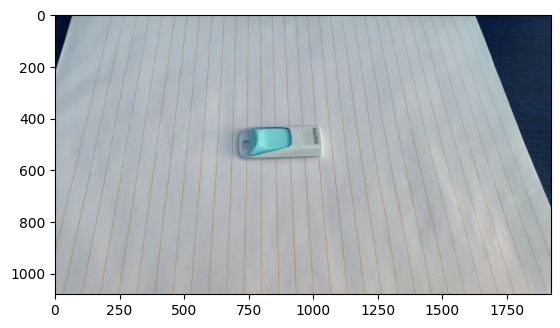

(<matplotlib.image.AxesImage at 0x250687f0e50>, None)

In [54]:
plt.imshow(frame),plt.show()

In [55]:
# Initial conditions
mu0 = np.zeros((4, ))
mu0[0] = x 
mu0[1] = y 
V0 = 0.1**2 *  np.eye(4) # Initial covariance

A = np.array([[1, 0, dt, 0], 
              [0, 1, 0, dt], 
              [0, 0, 1, 0],
              [0, 0, 0, 1]])
B = np.array([[0, 0],
              [0, 0],
              [dt/m, 0], 
              [0, dt/m]])

C = np.array([[1, 0, 0, 0], [0, 1, 0, 0]]) # Observation output on x and y positions

R = sigma_r**2 * np.eye(2) # Measurement covar matrix

Q = np.diag([epsilon, epsilon, sigma_q**2, sigma_q**2])

u = np.zeros((2, ))
kf = KalmanFilter(dim_x=4, dim_z=2)
kf.x = mu0
kf.P = V0 
kf.Q = Q 
kf.R = R 
kf.H = C 
kf.F = A 
kf.B = B 

In [56]:
# Create video writer, with 30 fps, size of og video
fourcc = cv.VideoWriter_fourcc(*'mp4v')
# fourcc = cv.VideoWriter_fourcc(*"MJPG")
video_out = cv.VideoWriter("out/test-mean_shift_kf.mp4", fourcc, 30, (1920, 1080))
obs = np.zeros((4,))

In [57]:
while(1):
    ret, frame = cap.read()

    if ret == True:
        hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
        dst = cv.calcBackProject([hsv],[0],roi_hist,[0,180],1)

        # apply meanshift to get the new location
        ret, track_window = cv.meanShift(dst, track_window, term_crit)

        kf.predict()

        kf_states = kf.x 
        kf_x = int(kf_states[0])
        kf_y = int(kf_states[1])

        # Draw it on image
        last_x = x 
        last_y = y
        x,y,w,h = track_window
        img2 = cv.rectangle(frame, (x,y), (x+w,y+h), 255,2)
        img2 = cv.circle(img2, (kf_x, kf_y), 5, color=(0, 0, 255), thickness=-1)
        # x_dot = (x - last_x) / dt 
        # y_dot = (y - last_y) / dt 
        obs = np.array([x, y])
        kf.update(obs)
        
        
        video_out.write(img2)

    else:
        break

In [58]:
cap.release()
video_out.release()
cv.destroyAllWindows()
os.system("ffmpeg -hide_banner -loglevel error -y -i out/test-mean_shift_kf.mp4 -vcodec libx264 out/test-mean_shift_kf_valid.mp4")

1

In [59]:
Video("out/test-mean_shift_kf.mp4")